In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from plotnine import *

In [54]:
# load in pre-cleaned deaths data for Texas and comparison states
deaths = pd.read_csv("05_cleaned_data/deaths_tx.csv")


In [55]:
# two separate dfs - one for texas and one for comp states

texas = deaths[deaths["StateName"] == "Texas"]
comp = deaths[deaths["StateName"] != "Texas"]

### Helper functions 

In [56]:
# function to select only overdose records
# double check this

def select_overdose(record):
    """Simple function to select only overdose records"""

    if record == "All other non-drug and non-alcohol causes":
        return 0

    if record == "All other alcohol-induced causes":
        return 0

    if record == "All other drug-induced causes":
        return 0

    if record == "Alcohol poisonings (overdose) (X45, X65, Y15)":
        return 0

    if record == "Drug poisonings (overdose) Unintentional (X40-X44)":
        return 1

    if record == "Drug poisonings (overdose) Suicide (X60-X64)":
        return 1

    if record == "Drug poisonings (overdose) Undetermined (Y10-Y14)":
        return 1

    else:
        return "error"
    

# copy to fix the dreaded "A value is trying to be set on a copy of a slice" error
tx_deaths = texas.copy()
comp_deaths = comp.copy()

# apply new function to our df
tx_deaths["overdose"] = tx_deaths["Drug/Alcohol Induced Cause"].apply(lambda x: select_overdose(x))
comp_deaths["overdose"] = comp_deaths["Drug/Alcohol Induced Cause"].apply(lambda x: select_overdose(x))

# filter accordingly based on new column
tx_deaths = tx_deaths[tx_deaths["overdose"] != 0]
comp_deaths = comp_deaths[comp_deaths["overdose"] != 0]

In [57]:
# calculate overdoses per 100_000 residents

tx_deaths["overdose_per_100k"] = tx_deaths["Deaths"] / tx_deaths["Population"] * 100_000
comp_deaths["overdose_per_100k"] = comp_deaths["Deaths"] / comp_deaths["Population"] * 100_000

In [58]:
tx_result = tx_deaths.groupby(["Year"])["overdose_per_100k"].sum().reset_index()
comp_result = comp_deaths.groupby(["Year", "StateName"])["overdose_per_100k"].sum().reset_index()

# keep validating num counties

In [59]:
#tx_result = tx_deaths.groupby(["Year", "County"])["overdose_per_100k"].sum().reset_index()

#tx_result.groupby("Year")["overdose_per_100k"].mean()

In [60]:
# collapse state column with a mean aggregation
# gives us the average overdoses of our comparison states over the years
comp_result = comp_result.groupby(["Year"])["overdose_per_100k"].mean().reset_index()

In [61]:
# create a scale for number of years before and after 2007 (target year)

def scale_years(year):
    if year == 2004:
        return -3
    if year == 2005:
        return -2
    if year == 2006:
        return -1
    if year == 2007:
        return 0
    if year == 2008:
        return 1
    if year == 2009:
        return 2
    if year == 2010:
        return 3

tx_result["year relative to policy"] = tx_result["Year"].apply(lambda x: scale_years(x))
comp_result["year relative to policy"] = comp_result["Year"].apply(lambda x: scale_years(x))

# double check no nulls in "year relative to policy"

assert (tx_result["year relative to policy"].isnull().sum() == 0)
assert (comp_result["year relative to policy"].isnull().sum() == 0)

# doing this in case the float == int comparison causes issues

In [62]:
# function to create vertical line for our pre-post plot
# line will appear in our target year (2007, in this case)

# NOT CURRENTLY WORKING
rules = alt.Chart(pd.DataFrame({
  'Year': [2007],
  'color': ['green']
})).mark_rule().encode(
  x='Year:Q',
  color=alt.Color('color:N', scale=None)
)

rules

c:\Users\abzdel\AppData\Local\Programs\Python\Python39\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


alt.Chart(...)

In [63]:
rules # when replacing q with t

alt.Chart(...)

## Pre-post plot - overdoses per 100k through the years

In [64]:
# split into before 2007 and after 2007

tx_b4 = tx_result[tx_result["Year"] < 2007]
tx_after = tx_result[tx_result["Year"] >= 2007]


tx_after = tx_after[tx_after["Year"] != 2007] # may need to handle this differently

In [65]:
from sklearn.linear_model import LinearRegression 

regressor_b4 = LinearRegression() 
regressor_after = LinearRegression()


X_b4 = np.array(tx_b4["year relative to policy"]).reshape(-1, 1)
y_b4 = np.array(tx_b4["overdose_per_100k"]).reshape(-1, 1)

X_after = np.array(tx_after["year relative to policy"]).reshape(-1, 1)
y_after = np.array(tx_after["overdose_per_100k"]).reshape(-1, 1)


regressor_b4.fit(X_b4,y_b4) 
regressor_after.fit(X_after,y_after) 


y_pred_b4 = regressor_b4.predict(X_b4)
y_pred_after = regressor_after.predict(X_b4)



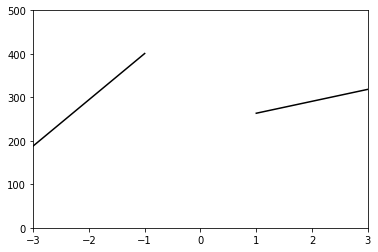

In [66]:
plt.xlim(-3, 3)
plt.ylim(0, 500)

plt.plot(X_b4, y_pred_b4,color='k')
plt.plot(X_after, y_pred_after,color='k')


In [67]:
# diff in diff

In [68]:
comp_b4 = comp_result[comp_result["Year"] < 2007]
comp_after = comp_result[comp_result["Year"] >= 2007]

comp_after = comp_after[comp_after["Year"] != 2007] # may need to handle this differently


In [69]:
regressor_b4 = LinearRegression() 
regressor_after = LinearRegression()


X_b4 = np.array(comp_b4["year relative to policy"]).reshape(-1, 1)
y_b4 = np.array(comp_b4["overdose_per_100k"]).reshape(-1, 1)

X_after = np.array(comp_after["year relative to policy"]).reshape(-1, 1)
y_after = np.array(comp_after["overdose_per_100k"]).reshape(-1, 1)


regressor_b4.fit(X_b4,y_b4) 
regressor_after.fit(X_after,y_after) 


y_pred_b4 = regressor_b4.predict(X_b4)
y_pred_after = regressor_after.predict(X_b4)



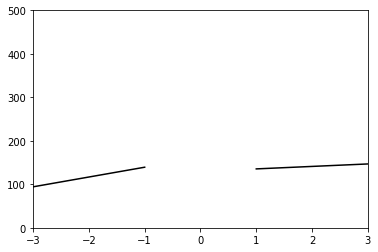

In [70]:
plt.xlim(-3, 3)
plt.ylim(0, 500)

plt.plot(X_b4, y_pred_b4,color='k')
plt.plot(X_after, y_pred_after,color='k')
